# CMSC320 Final Project: Chess Data Analysis
##### *Mohammad Durrani and Pranav Shah*

### Contents
1. [Introduction](##1.-Introduction)
2. [Required Tools](##2.-Required-Tools)
3. [About The Data](##3.-About-The-Data)
4. [Data Collection: Scraping](##4.-Data-Collection:-Scraping)
5. [Data Processing: Cleaning](##5.-Data-Processing:-Cleaning)
6. [Exploratory Data Analysis](##6.-Exploratory-Data-Analysis)
7. [Future Work and Conclusion](##7.-Future-Work-and-Conclusion)
8. [References and Additional Resources](##8.-References-and-Additional-Resources)

## 1. Introduction

## 2. Required Libraries

In [2]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install chess
!{sys.executable} -m pip install category-encoders

## 3. About The Data

## 4. Data Collection: Scraping

In [3]:
import chess.pgn
import pandas as pd
import glob
import numpy as np

#pgnFilePath =  r"\\wsl.localhost\Ubuntu\home\mdurrani\lichess_db_standard_rated_2024-03.pgn"
pgnFilePath = r'./data/*.pgn'
#outputFilePath = "./evaluations.csv"
totalGameCount = 0
totalEvalGameCount = 0
fileList = [] #glob.glob(pgnFilePath) # modify this line for the directory that has all the pgn files 
rows_list = [] # list of dictionaries for each game 
for file in fileList:
    pgn = open(fileList[0])
    game = chess.pgn.read_game(pgn)
    while game != None:
        totalGameCount += 1
        variations = game.variations # list of either the eval or clock score
        if(totalGameCount % 2000 == 0): # print every 2000 games
            print("Total Game Count: ", totalGameCount)
            print("Eval Game Count: ", totalEvalGameCount)
        if(totalGameCount % 1000000 == 0):
            df = pd.DataFrame(rows_list) # add everything to the dataframe 
            df.to_csv(outputFilePath)
        if(len(variations) > 0 and 'eval' in variations[0].comment): # if this game was evaluated by a computer, add it
            totalEvalGameCount+=1
            h = game.headers
                
            # adding a dictionary is faster than appending to a dataframe 
            rows_list.append({
                "UTCDate": h.get("UTCDate", np.NaN),
                "UTCTime": h.get("UTCTime", np.NaN),
                'WhiteElo': h.get('WhiteElo', np.NaN),
                'BlackElo': h.get('BlackElo', np.NaN),
                "Opening": h.get("Opening", np.NaN),
                "ECO": h.get("ECO", np.NaN),
                'Result': h.get('Result', np.NaN),
                "Termination": h.get("Termination", np.NaN),
                "Variations": str(variations[0]) if variations else np.NaN,
                'WhiteRatingDiff': h.get('WhiteRatingDiff', np.NaN),
                'BlackRatingDiff': h.get("BlackRatingDiff", np.NaN)
            })

        # Iterator reading next game
        game = chess.pgn.read_game(pgn)          

## 5. Data Processing: Cleaning

In [109]:
import pandas as pd 
import re

# Read data back in from csv and ignore the first column because it just contains the indicies.
# We only want white and black elo, opening category, result, and variations
smallDataset = "miniEvaluations.csv"
fullDataset = "evaluations.csv"
df= pd.read_csv(smallDataset, usecols=["WhiteElo", "BlackElo", "ECO", "Result", "Variations"])

# All data will be from the perspective of white 

# Get mistake differential from a game
def getMistakeDifferentials(variation):
    # Find all evaluations
    evalText = re.findall(r'%eval -?\d.\d*', variation)
    # Truncate text and get float eval value
    evalList = []
    for eval in evalText:
        evalList.append(float(eval.split(" ")[1]))

    # Find the mistake differential for white
    evalDifference = 0
    whiteBlunders = 0
    blackBlunders = 0
    whiteMistakes = 0
    blackMistakes = 0
    whiteInaccuracies = 0
    blackInaccuracies = 0
    for i in range(len(evalList)):
        if i != 0:
            evalDifference = evalList[i] - evalList[i-1]
        if abs(evalDifference) > 3:
            if i % 2 == 0:
                whiteBlunders += 1
            else:
                blackBlunders += 1
        elif abs(evalDifference) > 1:
            if i % 2 == 0:
                whiteMistakes += 1
            else:
                blackMistakes += 1
        elif abs(evalDifference) > 0.5:
            if i % 2 == 0:
                whiteInaccuracies += 1
            else:
                blackInaccuracies += 1
    blunderDifferential = whiteBlunders - blackBlunders
    mistakeDifferential = whiteMistakes - blackMistakes
    inaccuracyDifferential = whiteInaccuracies - blackInaccuracies
    return pd.Series({"BlunderDifferential" : blunderDifferential, "MistakeDifferential" : mistakeDifferential, 
                      "InaccuracyDifferential" : inaccuracyDifferential})

# Get time differential from a game
def getTimeDifferential(variation):
    # Find all clock text
    clockText = re.findall(r'%clk \d:\d{2}:\d{2}', variation)
    # Truncate text and get clock data in seconds
    clockList = []
    for clock in clockText:
        time = clock.split(" ")[1]
        hr = int(time.split(":")[0])
        min = int(time.split(":")[1])
        sec = int(time.split(":")[2])
        totalSeconds = hr * 3600 + min * 60 + sec
        clockList.append(totalSeconds)

    # Get clock differential
    whiteEndClock = 0
    blackEndClock = 0
    # If less than 2 moves, can't calculate time differential
    whiteBeginClock = 0
    if len(clockList) >= 2:
        whiteBeginClock = clockList[0]
        if len(clockList) % 2 == 0:
            whiteEndClock = clockList[-2]
            blackEndClock = clockList[-1]
        else:
            whiteEndClock = clockList[-1]
            blackEndClock = clockList[-2]
    timeDifferential = whiteEndClock - blackEndClock 

    return pd.Series({"TimeDifferential": timeDifferential, "TimeControl": whiteBeginClock})

def getMoves(variation):
    moves = re.findall(r'%eval -?\d.\d*', variation)
    # Even out moves to prevent it from giving away winner
    if len(moves) % 2 != 0:
        return len(moves) + 1
    return len(moves)

def getDevelopmentDifferential(variation):
    moves = re.findall(r'\d+\.+\s[\w-]+',variation)
    moveList = []
    for move in moves:
        moveList.append(move.split(" ")[1])
        
    whiteNonPawnMoves = 0
    whiteCastleTime = 0
    blackNonPawnMoves = 0
    blackCastleTime = 0
    for i in range(len(moveList)):
        if i<=30 and moveList[i][0] in ["N","B","R","Q","K","O"]:
            if i % 2 == 0:
                if moveList[i][0] == "O":
                    whiteCastleTime = i//2
                whiteNonPawnMoves+=1
            else:
                if moveList[i][0] == "O":
                    blackCastleTime = i//2
                blackNonPawnMoves+=1
    nonPawnMoveDifferential = whiteNonPawnMoves - blackNonPawnMoves
    castleTimeDifferential = whiteCastleTime - blackCastleTime
    return pd.Series({"DevelopmentDifferential": nonPawnMoveDifferential, "KingSafetyDifferential": castleTimeDifferential}) 
# Turn string result into a number result 
def getResultForWhite(result):
    if result == "0-1":
        return 0
    elif result == "1-0":
        return 1
    else:
        return 0.5
    
df[["BlunderDifferential","MistakeDifferential","InaccuracyDifferential"]] = df["Variations"].apply(getMistakeDifferentials)

df[["TimeDifferential","TimeControl"]] = df["Variations"].apply(getTimeDifferential)

df["Moves"] = df["Variations"].apply(getMoves)

df[["DevelopmentDifferential","KingSafetyDifferential"]] = df["Variations"].apply(getDevelopmentDifferential)

df["EloDifferential"] = df["WhiteElo"] - df["BlackElo"]

df["AverageElo"] = (df["WhiteElo"] + df["BlackElo"]) / 2

df["Result"] = df["Result"].apply(getResultForWhite)

df = df.drop(["Variations", "WhiteElo", "BlackElo"], axis=1)

pd.set_option('display.max_columns', None)
print(df.head())

   ECO  Result  BlunderDifferential  MistakeDifferential  \
0  B09     0.0                    0                    2   
1  C33     1.0                   -1                    0   
2  B12     1.0                   -1                   -2   
3  B13     1.0                    0                    1   
4  C40     1.0                    0                   -3   

   InaccuracyDifferential  TimeDifferential  TimeControl  Moves  \
0                       1               -26          180     36   
1                      -2                33          600     48   
2                       0               495         1800     48   
3                       2               531         1797     90   
4                      -3              -121          600     48   

   DevelopmentDifferential  KingSafetyDifferential  EloDifferential  \
0                       -1                       9               97   
1                       -1                       0             -128   
2                      

## 6. Exploratory Data Analysis

Let's plot the relationship between each of our differentials and the average result

Text(0, 0.5, 'Mean Result')

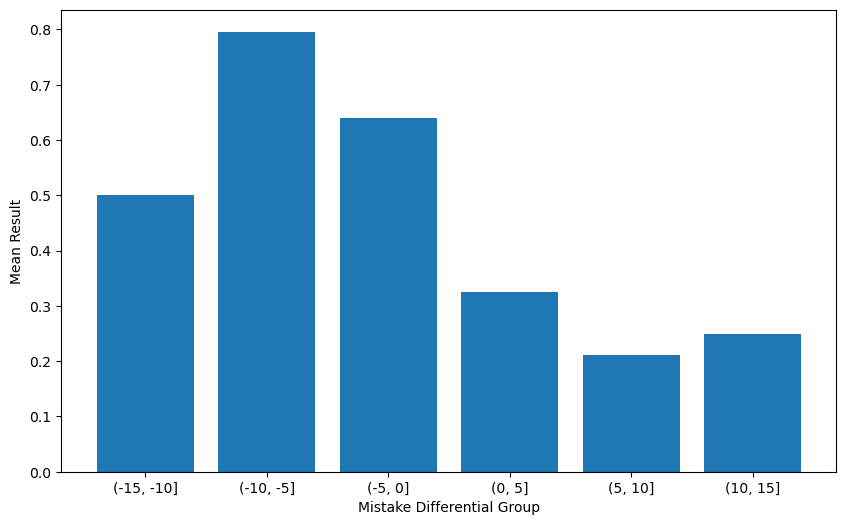

In [5]:
import matplotlib.pyplot as plt
bins =[-15,-10,-5,0,5,10,15]

df["MistakeGroup"] = pd.cut(df['MistakeDifferential'], bins=bins, precision=0)

# Drop na values caused by values that don't fit the bins
groups = df["MistakeGroup"].dropna().unique().sort_values()

x = range(len(groups))
y = df.groupby("MistakeGroup", observed=True)["Result"].mean()
plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.xticks(x, groups)
plt.xlabel('Mistake Differential Group')
plt.ylabel('Mean Result')

It seems that making less mistakes does influence winning. However, the graph does not show the straight correlation that was expected. This result may be due to mistakes varying in size: mistakes are classified as anything that changes the evaluation of the game by one or more, but regardless of the change in evaluation after 1, the mistakes are weighted the same. It seems that with a large mistake differential winning was less predictable. This is probably because the player with a mistake advantage must have made some very large mistakes.

Text(0, 0.5, 'Mean Result')

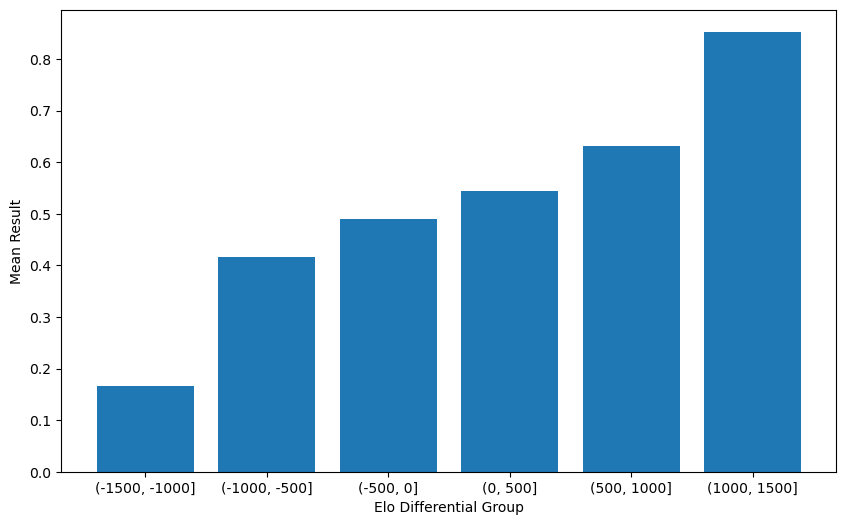

In [6]:
bins = [-1500,-1000,-500,0,500,1000,1500]
df["EloGroup"] = pd.cut(df['EloDifferential'], bins=bins, precision=0)

# Drop na values caused by values that don't fit the bins
groups = df["EloGroup"].dropna().unique().sort_values()

x = range(len(groups))
y = df.groupby("EloGroup", observed=True)["Result"].mean()
plt.figure(figsize=(10,6))
plt.bar(x, y)

plt.xticks(x, groups)
plt.xlabel('Elo Differential Group')
plt.ylabel('Mean Result')


The Elo Differential graph shows that elo has a clear correlation towards winning. The greater the differential between the player and their opponent, the greater the chance of winning. However elo doesn't impact the game significantly, at least not within a differential range of -500 to 500. As long as players were in that elo range they were only at a less than 5% disadvantage/advantage. This is much different from the mistake graph where having the mistake advantage could increase chances of winning by more than 20%.

Text(0, 0.5, 'Mean Result')

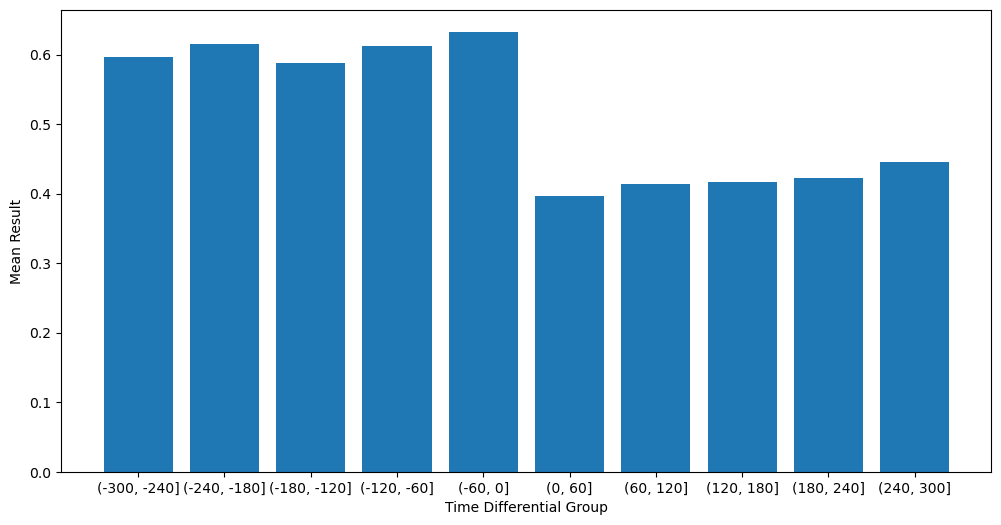

In [7]:
bins = [-300,-240,-180,-120,-60,0,60,120,180,240,300]
df["TimeGroup"] = pd.cut(df['TimeDifferential'],bins=bins, precision=0)

# Drop na values caused by values that don't fit the bins
groups = df["TimeGroup"].dropna().unique().sort_values()

x = range(len(groups))
y = df.groupby("TimeGroup", observed=True)["Result"].mean()
plt.figure(figsize=(12,6))
plt.bar(x, y)
plt.xticks(x, groups)
plt.xlabel('Time Differential Group')
plt.ylabel('Mean Result')

According to the graph, it seems that the only factor that influences winning is whether the player has the time advantage, not the quantity of that advantage. This makes sense as games can be won on time, so a significant decline in results can be seen near 0. 

Text(0, 0.5, 'Mean Result')

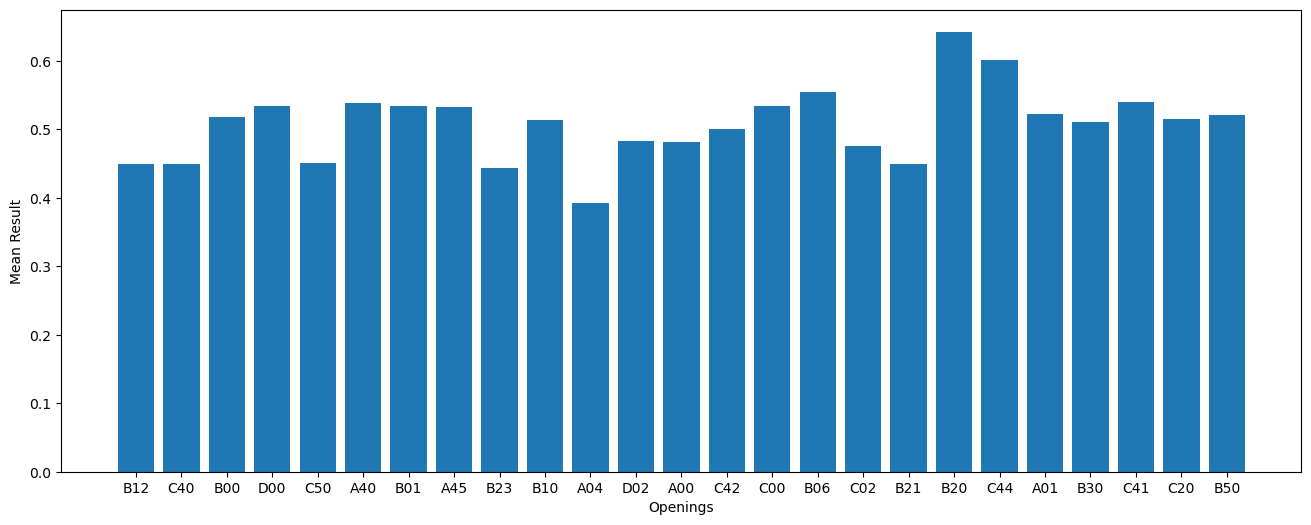

In [8]:
# Filter our df by openings that have at least 10000 games played, approximately 1% of the dataset. 
# We want frequently played openings because unusual openings have a large variance to their win percentage.
value_counts = df["ECO"].value_counts()

filtered_values = value_counts[value_counts > len(df.index)*.01].index
filtered_df = df[df['ECO'].isin(filtered_values)]

groups = filtered_df['ECO'].unique()

x = range(len(groups))
y = filtered_df.groupby("ECO", observed=True)["Result"].mean()
plt.figure(figsize=(16,6))
plt.bar(x, y)
plt.xticks(x, groups)
plt.xlabel('Openings')
plt.ylabel('Mean Result')

We filtered the data to only include openings that accounted for at least 1% of games in our database to get results with a low variance. The results show that openings do have a small impact on winning. The least and most winning openings differed by about 20%, with most openings hovering close to the 50% win rate.

Let's explore how our features behave with one another to get a better insight into how they impact winning!

Slope for EloDifferential vs MistakeDifferential: -0.0021524315160369673
Slope for EloDifferential vs TimeDifferential: -0.05152650469874304
Slope for TimeDifferential vs MistakeDifferential: 0.0010081137445628655


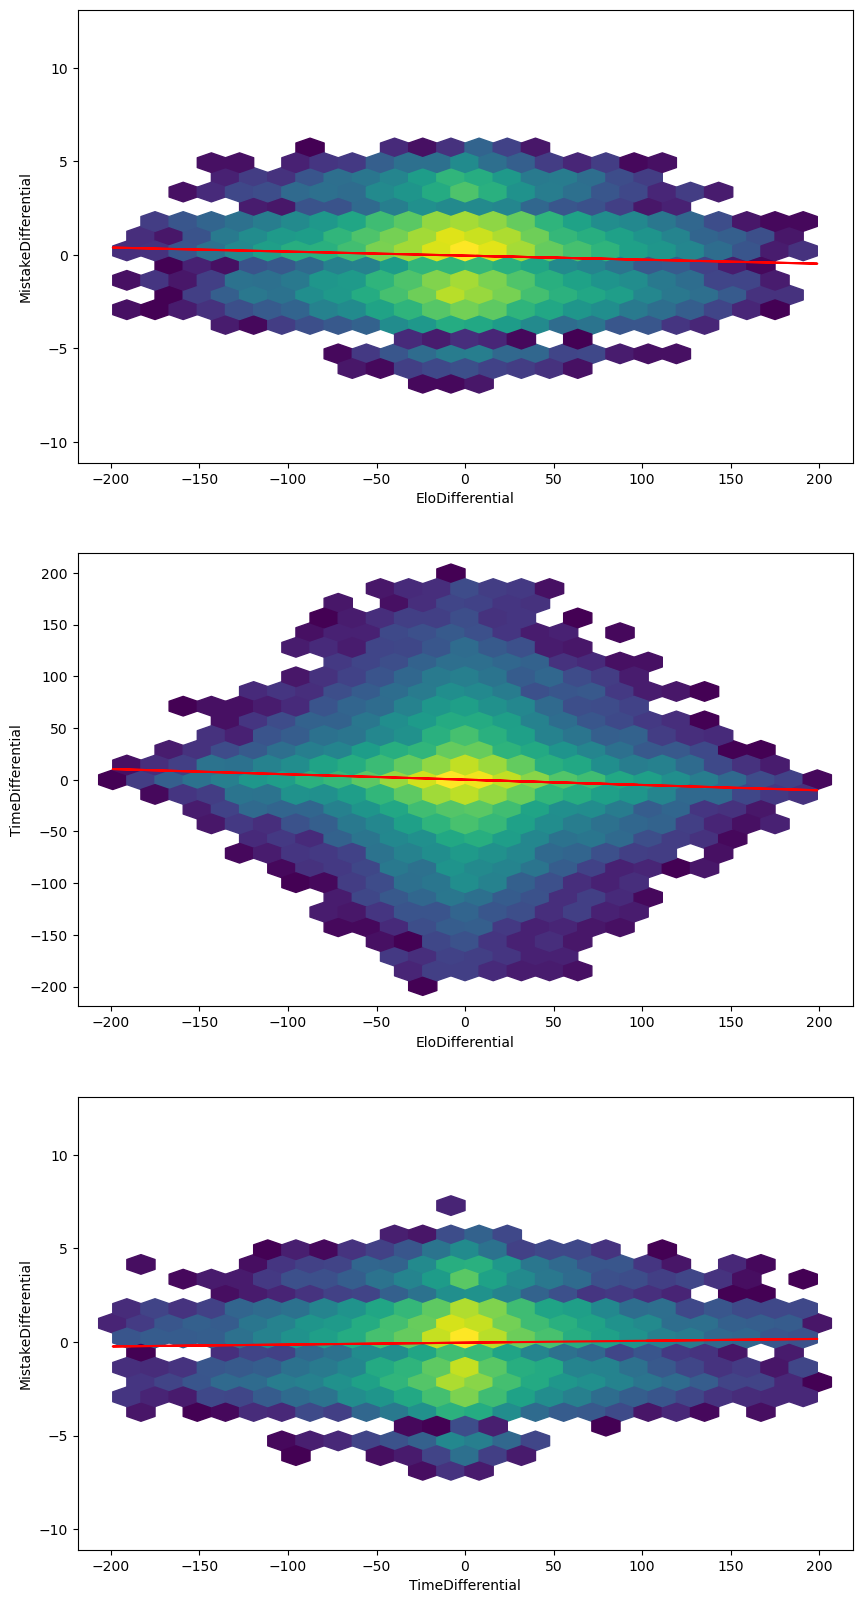

In [9]:
import numpy as np
# Filter dataframe to remove outliers to make axes smaller
mincnt = 300
# If using small dataset
if len(df.index) < 100000:
    mincnt = 10

# Filtering dataframe to remove outliers because outliers will expand the range of the graphs significantly and 
# make trends in the graph tougher to notice.
filtered_df = df[(abs(df["EloDifferential"]) < 200) & (abs(df["TimeDifferential"]) < 200)]
fig, axes = plt.subplots(3, 1, figsize=(10, 20))

axesArr = [("EloDifferential","MistakeDifferential"),("EloDifferential","TimeDifferential"),("TimeDifferential","MistakeDifferential")]
for i, ax in enumerate(axes.flat):
    x, y = axesArr[i]
    # Decided to use a hexbin as there is a signficant amount of data, so scatter plots wouldnt work well
    ax.hexbin(filtered_df[x],filtered_df[y],gridsize=25,mincnt=mincnt, bins="log")
    # Getting a line of best fit using linear regression
    m,b = np.polyfit(filtered_df[x],filtered_df[y],1)
    # Plotting this line 
    ax.plot(filtered_df[x],m*filtered_df[x]+b, 'r')
    print(f"Slope for {x} vs {y}: {m}")
    ax.set_xlabel(x)
    ax.set_ylabel(y)

plt.show()


The graphs above provide the correlation between our features and give us a more nuanced look at the impact of the features on winning rates. Hexbin graphs were chosen as there is a signficant amount of data, so scatter plots wouldnt work well. We also used linear regression to draw a line of best fit for each of these graphs.

The first graph between EloDifferential and MistakeDifferential shows that having a greater elo than your opponent can reduce your mistakes slightly. A close look at the hexbins shows this slight correlation. This makes sense intuitively as higher elo players are better than their opponents, and will make fewer mistakes. 

The second graph between EloDifferential and TimeDifferential also agrees with our past findings, having a greater elo will give a slight time advantage and therefore increase chances of winning. This graph also had a signficantly greater slope for its line of best fit than the other two, showing a much stronger correlation between these two characteristics. 

The third graph between TimeDifferential and MistakeDifferential, however, defies intuition. One would think that having a time disadvantage would cause a player to panic and make more mistakes, but there seems to be little to no correlation between the two variables. The slope of the line of best fit is about half that of the first graph and there is no noticable trend when looking at the hexbin graph. One explanation for this might be that games with a large time differential may end by time out, so mistakes wouldn't factor into the result. 

## 7. Machine Learning

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def convertWinToCategory(val):
    res = ""
    match val:
        case 1.0:
            res = "Win"
        case 0.0:
            res = "Loss" 
        case 0.5:
            res = "Tie"
    return res

train_feat_df = df.loc[:,["KingSafetyDifferential","DevelopmentDifferential","AverageElo","TimeControl", "Moves", "InaccuracyDifferential", "MistakeDifferential", "BlunderDifferential", "TimeDifferential", "EloDifferential", "ECO", "Result"]]

value_counts = train_feat_df["ECO"].value_counts()

filtered_values = value_counts[value_counts > len(train_feat_df.index)*.02].index
train_feat_df = train_feat_df[train_feat_df['ECO'].isin(filtered_values)]

# convert results to categorical values for training
train_feat_df["Result"] = train_feat_df["Result"].map(convertWinToCategory)

# Use pd.get_dummies to perform one-hot encoding
one_hot_enc_df = pd.get_dummies(train_feat_df["ECO"], prefix='ECO')
train_feat_df = pd.concat([train_feat_df, one_hot_enc_df], axis=1)
train_feat_df = train_feat_df.drop("ECO", axis = 1)

X = train_feat_df.drop("Result", axis=1)
y = train_feat_df["Result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

        Loss       0.81      0.81      0.81      1351
         Tie       0.04      0.75      0.07         4
         Win       0.84      0.79      0.82      1463

    accuracy                           0.80      2818
   macro avg       0.56      0.79      0.57      2818
weighted avg       0.83      0.80      0.81      2818



### Hyperparameter Optimization

In [120]:
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {'n_estimators':np.arange(50,200,15),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9],
              'max_samples': [0.3, 0.5, 0.8]}



random_search = RandomizedSearchCV(RandomForestClassifier(), 
                                   param_grid) 
random_search.fit(X_train, y_train)  
best_model = random_search.best_estimator_
print(best_model)

RandomForestClassifier(max_depth=9, max_features=0.7000000000000001,
                       max_samples=0.5, n_estimators=140)


In [121]:
best_model.fit(X_train, y_train) 
y_pred_rand = best_model.predict(X_test) 
print(classification_report(y_pred_rand, y_test)) 

              precision    recall  f1-score   support

        Loss       0.82      0.81      0.82      1361
         Tie       0.02      0.18      0.04        11
         Win       0.84      0.80      0.82      1446

    accuracy                           0.81      2818
   macro avg       0.56      0.60      0.56      2818
weighted avg       0.83      0.81      0.82      2818



In [122]:
important_features = zip(X.columns, best_model.feature_importances_)
imp_feat_df = pd.DataFrame(important_features)
imp_feat_df.rename(columns={0:'features',
                               1:'importance'},
                      inplace=True)
imp_feat_df.sort_values(by=['importance'], inplace=True, ascending=False)
imp_feat_df.reset_index(inplace=True)
imp_feat_df.drop(['index'], axis=1, inplace=True)
imp_feat_df

,features,importance
0,BlunderDifferential,0.321084
1,MistakeDifferential,0.202301
2,TimeDifferential,0.112530
3,Moves,0.086889
4,TimeControl,0.057776
5,AverageElo,0.052524
6,InaccuracyDifferential,0.046332
7,EloDifferential,0.041723
8,KingSafetyDifferential,0.027419
9,DevelopmentDifferential,0.019580


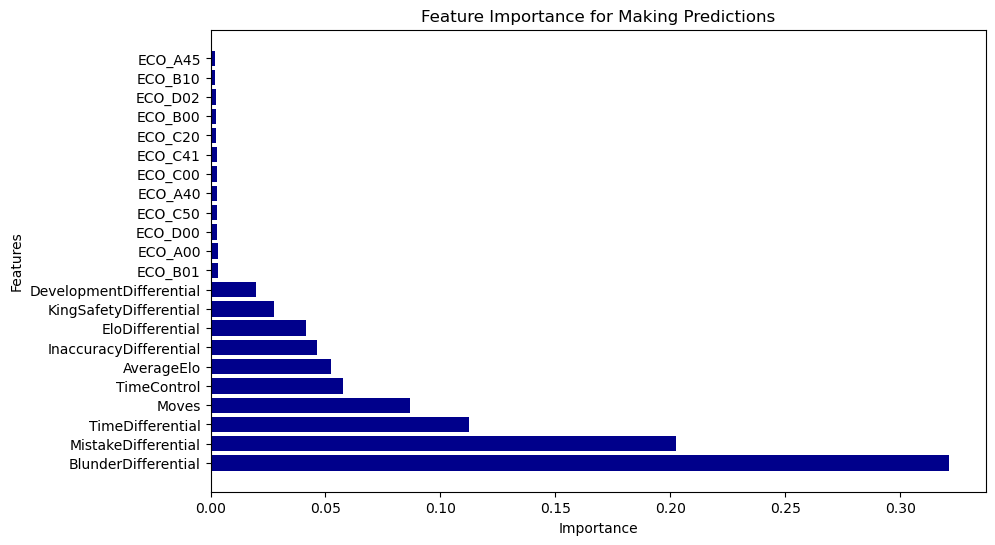

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(imp_feat_df['features'], imp_feat_df['importance'], color='darkblue')

plt.xlabel('Importance')
plt.ylabel('Features')

plt.title('Feature Importance for Making Predictions')

plt.show()


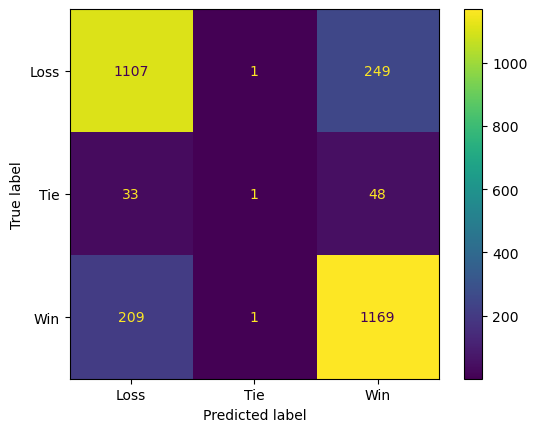

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_rand, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_model.classes_)
disp.plot()

plt.show()

## Further Benchmarking

In [124]:

import pandas as pd
from sklearn.metrics import accuracy_score
tolerance = 10

bench1 = X_test['EloDifferential'].apply(lambda x: "Win" if x > tolerance else ("Loss" if x < -tolerance else "Tie"))

bench2 = np.random.choice(["Loss", "Tie", "Win"], size=len(X_test))

bench3 = y_pred

bench4 = y_pred_rand

ground_truth = y_test


data = {'Greater ELO Wins': bench1, 'Random Guess': bench2, 'predictions (no hyperparameter)': bench3, 'predictions (hyperparameter)': bench4,'ground_truth': ground_truth}
test_df = pd.DataFrame(data)

accuracy_bench1 = accuracy_score(test_df['ground_truth'], test_df['Greater ELO Wins'])
accuracy_bench2 = accuracy_score(test_df['ground_truth'], test_df['Random Guess'])
accuracy_bench3 = accuracy_score(test_df['ground_truth'], test_df['predictions (no hyperparameter)'])
accuracy_bench4 = accuracy_score(test_df['ground_truth'], test_df['predictions (hyperparameter)'])


print(f"Accuracy of Greater ELO Wins Benchmark: {accuracy_bench1*100:.2f}%")
print(f"Accuracy of Randomly Guessing Winner: {accuracy_bench2*100:.2f}%")
print(f"Accuracy of Random Forest Predictions (w/o hyperparameter): {accuracy_bench3*100:.2f}%")
print(f"Accuracy of Random Forest Predictions (w/ hyperparameter): {accuracy_bench4*100:.2f}%")



Accuracy of Greater ELO Wins Benchmark: 42.33%
Accuracy of Randomly Guessing Winner: 32.90%
Accuracy of Random Forest Predictions (w/o hyperparameter): 80.41%
Accuracy of Random Forest Predictions (w/ hyperparameter): 80.59%


## 8. Future Work and Considerations

## 9. References and Additional Resources